## Perturb data initial condition

In [322]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [323]:
import os
import sys

script_path = os.path.realpath(os.path.dirname(__name__))
os.chdir(script_path)
sys.path.append("/workspace/collab-environment/")
sys.path.append("/workspace/collab-environment/collab_env/gnn")
sys.path.append("/workspace/collab-environment/collab_env/data/boids")

In [324]:
from itertools import combinations
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn.functional as functional
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from collab_env.data.file_utils import expand_path, get_project_root

In [325]:
from collab_env.gnn.gnn import get_adjcency_from_debug, plot_log_loss, train_rules_gnn, load_model, save_model, debug_result2prediction
from collab_env.gnn.gnn_definition import GNN, Lazy
from collab_env.data.boids.animal_simulation import visualize_graph_2sets, static_visualize_2sets

from collab_env.gnn.utility import dataset2testloader
from collab_env.gnn.plotting_utility import load_various_data, load_rollout
from collab_env.sim.boids_gnn_temp.boid import update_boids, update_boids_with_food


In [326]:
smoke_test = "CI" in os.environ
save_file = True if not smoke_test else False
steps = 50 if not smoke_test else 5

In [327]:
width, height = 480, 480

In [328]:
data_names = ['boid_single_species_basic','boid_single_species_independent',
              'boid_food_basic','boid_food_independent'] #'runpod/boid_single_species_basic']

data_names_short = {}
data_names_short['boid_single_species_independent'] = 'idpnt'
data_names_short['boid_single_species_basic'] = 'boid'
data_names_short['boid_food_basic'] = 'foodbasic'
data_names_short['boid_food_independent'] = 'foodidpnt'
data_names_short['boid_food_strong'] = 'foodstrong'

In [329]:
def form_initial_boids(pos0, pos1, sigma = 0):

    boids = []
    for b_ind in range(pos0.shape[0]):
        noise = np.random.normal(0, np.ones_like(pos0[b_ind, :]) * sigma)
        
        b = {"x": pos0[b_ind, 0] * width, "y": pos0[b_ind, 1] * height,
             "dx": ((pos1[b_ind, 0] - pos0[b_ind, 0]) + noise[0]) * width,
             "dy": ((pos1[b_ind, 1] - pos0[b_ind, 1]) + noise[1]) * height,
             'perching_time': 0,
                'satiated': 0,
                'eating': 0,
                'food_time': 0,
             "species": 'A'}
        boids.append(b)
    return boids

In [330]:
def update(boids, species_configs, T = 50, food = False):
    """use the update functions from simulation script."""
    pos_re = []
    v_re = []
    
    for t in range(T):
        p = np.array([[b['x']/width, b['y']/height] for b in boids], dtype=np.float32)
        v = np.array([[b['dx']/width, b['dy']/height] for b in boids], dtype=np.float32)
    
        pos_re.append(p)
        v_re.append(v)

        if food:
            update_boids_with_food(boids, width, height, species_configs)
        else:
            update_boids(boids, width, height, species_configs)
        
    pos_re = torch.tensor(np.array(pos_re))
    v_re = torch.tensor(np.array(v_re))

    return pos_re, v_re

In [221]:
datasets = load_various_data(data_names, 1, return_dict = True)

In [303]:
d_name = 'boid_food_basic'

dataset = datasets[d_name]
species_configs = dataset['species_configs']
test_loader = dataset['test_loader']

In [306]:
file_id = 13

pos, species = list(test_loader)[file_id]
pos0 = pos[0,0].detach().numpy()
pos1 = pos[0,1].detach().numpy()

boids = form_initial_boids(pos0, pos1, sigma = 0)
pos_no_noise, v_no_noise = update(boids, species_configs, food = True, T = steps)

sigma = 0.005
boids = form_initial_boids(pos0, pos1, sigma = sigma)
pos_noise, v_noise = update(boids, species_configs, food = True, T = steps)

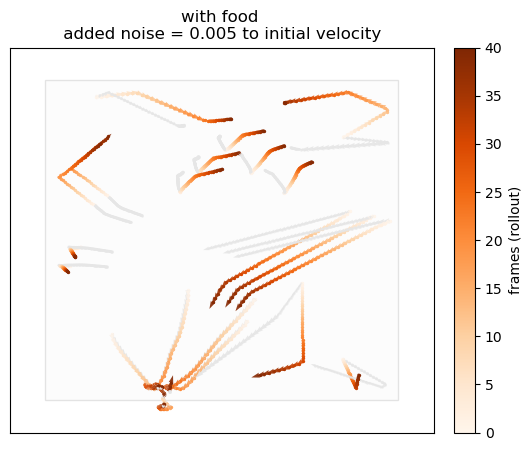

In [307]:
ax = static_visualize_2sets(pos_no_noise, v_no_noise, pos_noise, v_noise,
                starting_frame = 0, rollout_starting_frame = 0, 
                ending_frame = 40)
ax.set_title(f"with food \n added noise = {sigma} to initial velocity ")
if save_file:
    plt.savefig(f"initial velocity perturbation {d_name}.pdf", bbox_inches="tight")

In [294]:
d_name = 'boid_single_species_basic'

dataset = datasets[d_name]
species_configs = dataset['species_configs']
test_loader = dataset['test_loader']

In [299]:
file_id = 1

pos, species = list(test_loader)[file_id]
pos0 = pos[0,0].detach().numpy()
pos1 = pos[0,1].detach().numpy()

boids = form_initial_boids(pos0, pos1, sigma = 0)
pos_no_noise, v_no_noise = update(boids, species_configs, food = False, T = steps)

sigma = 0.005
boids = form_initial_boids(pos0, pos1, sigma = sigma)
pos_noise, v_noise = update(boids, species_configs, food = False, T = steps)

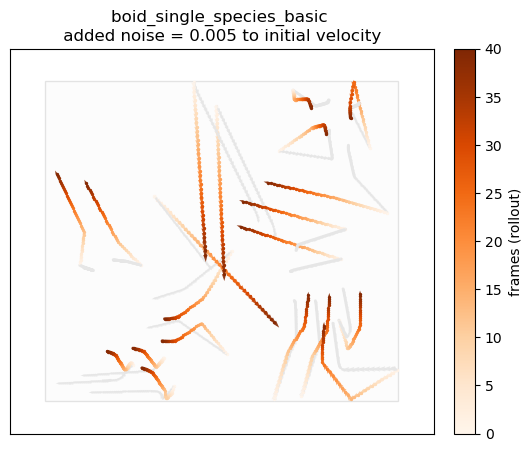

In [301]:
ax = static_visualize_2sets(pos_no_noise, v_no_noise, pos_noise, v_noise,
                starting_frame = 0, rollout_starting_frame = 0, 
                ending_frame = 40)
ax.set_title(f"{d_name} \n added noise = {sigma} to initial velocity ")
if save_file:
    plt.savefig(f"initial velocity perturbation {d_name}.pdf", bbox_inches="tight")

### Across files

In [244]:
def sqr_diff_torch(pred, actual):
    return torch.mean(torch.sqrt(torch.sum((pred - actual) ** 2, axis = 2))[:,:20], axis = 1)

In [243]:
def sqr_diff_np(pred, actual):
    return np.mean(np.sqrt(np.sum((pred - actual) ** 2, axis = 2))[:,:20], axis = 1)

In [308]:
diff = {}
diff2 = {}

for d_name in datasets:
    
    dataset = datasets[d_name]
    species_configs = dataset['species_configs']
    test_loader = dataset['test_loader']

    starting_frame = 0
    end_frame = 80
    
    Sqrdiff = []
    Sqrdiff2 = []
    
    for file_id in range(300): #range(len(list(test_loader))):
        pos, species = list(test_loader)[file_id]
        pos0 = pos[0,0].detach().numpy()
        pos1 = pos[0,1].detach().numpy()
        
        boids = form_initial_boids(pos0, pos1, sigma = 0)
        pos_no_noise, v_no_noise = update(boids, species_configs, end_frame + 1, T = steps)
        
        sigma = 0.005
        boids = form_initial_boids(pos0, pos1, sigma = sigma)
        pos_noise, v_noise = update(boids, species_configs, end_frame + 1, T = steps)
    
        Sqrdiff.append(sqr_diff_torch(pos_noise, pos_no_noise))
    
        sigma = 0.01
        boids = form_initial_boids(pos0, pos1, sigma = sigma)
        pos_noise, v_noise = update(boids, species_configs, end_frame + 1, T = steps)
    
        Sqrdiff2.append(sqr_diff_torch(pos_noise, pos_no_noise))

    Sqrdiff_ = torch.hstack([s.reshape((-1,1)) for s in Sqrdiff])
    Sqrdiff2_ = torch.hstack([s.reshape((-1,1)) for s in Sqrdiff2])

    mean1 = torch.mean(Sqrdiff_, axis = 1)
    sd1 = torch.std(Sqrdiff_, axis = 1)

    mean2 = torch.mean(Sqrdiff2_, axis = 1)
    sd2 = torch.std(Sqrdiff2_, axis = 1)
        
    diff[d_name] = mean1, sd1
    diff2[d_name] = mean2, sd2

Text(0.5, 1.0, 'Boid with food')

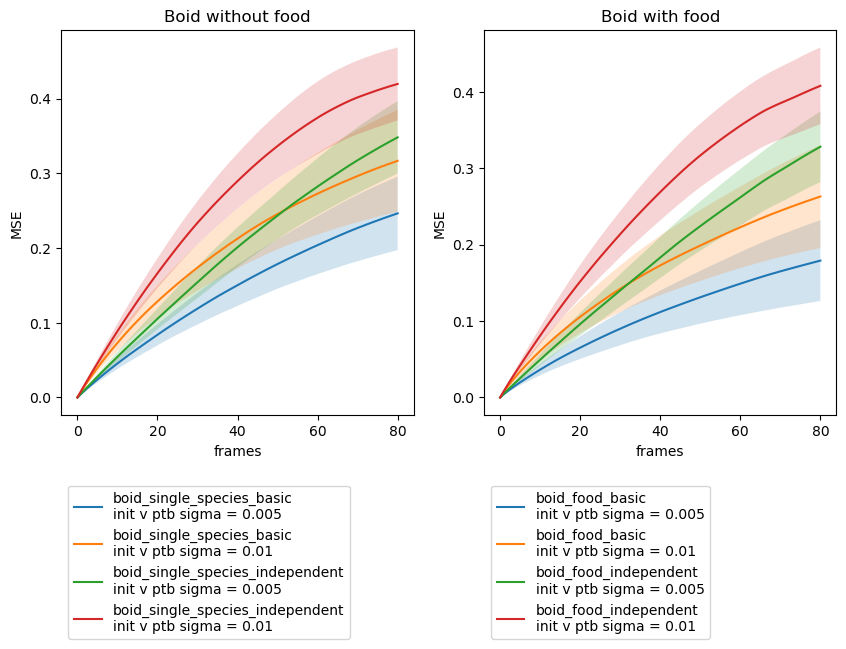

In [312]:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(10, 5))

for d_name in datasets:
    mean1, sd1 = diff[d_name]
    mean2, sd2 = diff2[d_name]

    if 'food' in d_name:
        ax = axes[1]
    else:
        ax = axes[0]
        
        
    ax.plot(mean1, label = d_name + "\ninit v ptb sigma = 0.005")
    ax.fill_between(np.arange(len(mean1)), mean1 - sd1, mean1 + sd1, alpha = 0.2)
    
    ax.plot(mean2, label = d_name + "\ninit v ptb sigma = 0.01")
    ax.fill_between(np.arange(len(mean2)), mean2 - sd2, mean2 + sd2, alpha = 0.2)
    
    ax.legend(bbox_to_anchor=(0, -0.6), loc='lower left')
    ax.set_xlabel("frames")
    ax.set_ylabel("MSE")

axes[0].set_title("Boid without food")
axes[1].set_title("Boid with food")

### Rollout

In [337]:
all_combinations = [
    ('boid_single_species_basic', 'vpluspplus_a', 0.005, 1, 0.5, 2, 0),
    ('boid_single_species_independent', 'vpluspplus_a', 0.005, 1, 0.5, 3, 0),

    ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 2, 0),
    #('boid_food_independent', 'vpluspplus_a', 0, 3, 0.5, 0),
    ('boid_food_independent', 'vpluspplus_a', 0.005, 3, 0.5, 4, 0),
]

In [338]:
rollout_results =  {}

model_names = {}
for ind in range(len(all_combinations)):

    data_name, model_name, n, h, vr, s, ablation = all_combinations[ind]

    print("ablation ", ablation)

    #if ablation:
    #    old_format = True
    #else:
    old_format = True
    spec = {
        "data_name": data_name,
        "head": h,
        "visual_range": vr,
        "seed": s,
        "rollout_starting_frame": 5,
        "noise": n,
        "seed": s,
        "old_format": old_format,
        "ablate": ablation
    }
    
    data_name_short = data_names_short[data_name]
    if ablation:
        model_save_name = f'{data_name_short}_\nn{n}_h{h}_vr{vr}_s{s}_ablation'
    else:
        model_save_name = f'{data_name_short}_\nn{n}_h{h}_vr{vr}_s{s}'

    
    #try:
        
    rollout_results[ind] = load_rollout(
            "vpluspplus_a", **spec)
    model_names[ind] = model_save_name
    print(f"{ind}, Successfully import {model_save_name}")
    #except:
    #    print(f"Cannot import {model_save_name}")


ablation  0
/workspace/collab-environment/trained_models/runpod/boid_single_species_basic/rollouts/boid_single_species_basic_vpluspplus_a_n0.005_h1_vr0.5_s2_rollout5.pkl
0, Successfully import boid_
n0.005_h1_vr0.5_s2
ablation  0
/workspace/collab-environment/trained_models/runpod/boid_single_species_independent/rollouts/boid_single_species_independent_vpluspplus_a_n0.005_h1_vr0.5_s3_rollout5.pkl
1, Successfully import idpnt_
n0.005_h1_vr0.5_s3
ablation  0
/workspace/collab-environment/trained_models/runpod/boid_food_basic/rollouts/boid_food_basic_vpluspplus_a_n0.005_h3_vr0.5_s2_rollout5.pkl
2, Successfully import foodbasic_
n0.005_h3_vr0.5_s2
ablation  0
/workspace/collab-environment/trained_models/runpod/boid_food_independent/rollouts/boid_food_independent_vpluspplus_a_n0.005_h3_vr0.5_s4_rollout5.pkl
3, Successfully import foodidpnt_
n0.005_h3_vr0.5_s4


In [339]:
def return_mse(rollout_result, starting_frame, end_frame):
    
    F = len(rollout_result[0]['predicted']) #frames
    mse_by_frame = []
    std_by_frame = []
    for f in range(starting_frame, end_frame):
        Sqrdiff = []
        for b in rollout_result:
            pred = rollout_result[b]['predicted'][f]
            actual = rollout_result[b]['actual'][f]
            Sqrdiff.append(sqr_diff_np(pred, actual))

        mse_by_frame.append(np.mean(np.concatenate(Sqrdiff, axis = 0)))
        std_by_frame.append(np.std(np.concatenate(Sqrdiff, axis = 0)))
    return np.array(mse_by_frame), np.array(std_by_frame)

Text(0.5, 1.0, 'with food ')

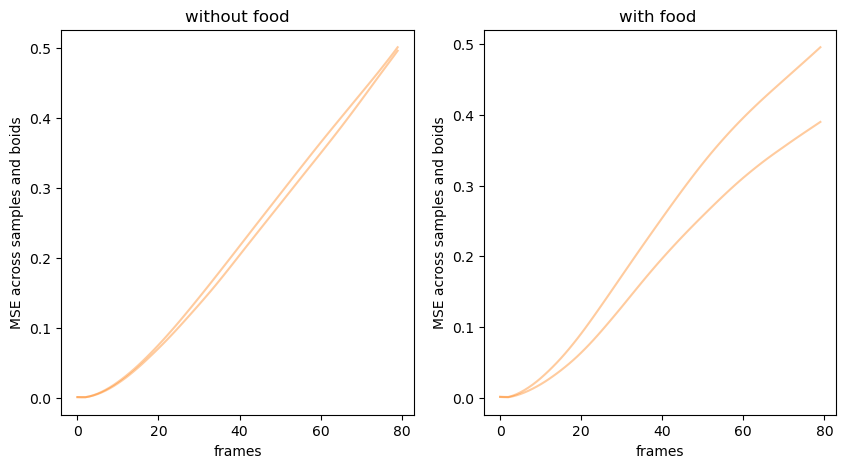

In [340]:
starting_frame = 0
end_frame = 80

mse_by_frame_all = []
mse_by_frame_all_dict = {} #fool-proof

fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(10, 5))

for m in rollout_results:
    if "food" in model_names[m]:
        ax = axes[1]
    else:
        ax = axes[0]
        
    
    mse_by_frame, std_by_frame = return_mse(rollout_results[m][0], starting_frame, end_frame)
    if mse_by_frame[60] <= 0.5:
        label = model_names[m]
    else:
        label = None

    # tally
    mse_by_frame_all.append(mse_by_frame)
    mse_by_frame_all_dict[m] = np.sum(mse_by_frame)
        
    ax.plot(mse_by_frame, label = label, color = c, alpha = 0.4)

for ax in axes:
    #ax.set_ylim([-1,2])
    ax.set_xlabel('frames')
    ax.set_ylabel('MSE across samples and boids')

#axes[0].legend(bbox_to_anchor=(0, -0.8), loc='lower left')
#axes[1].legend(bbox_to_anchor=(0, -0.8), loc='lower left')
axes[0].set_title("without food")
axes[1].set_title("with food ")

### Put perturbation and data on the same plot!

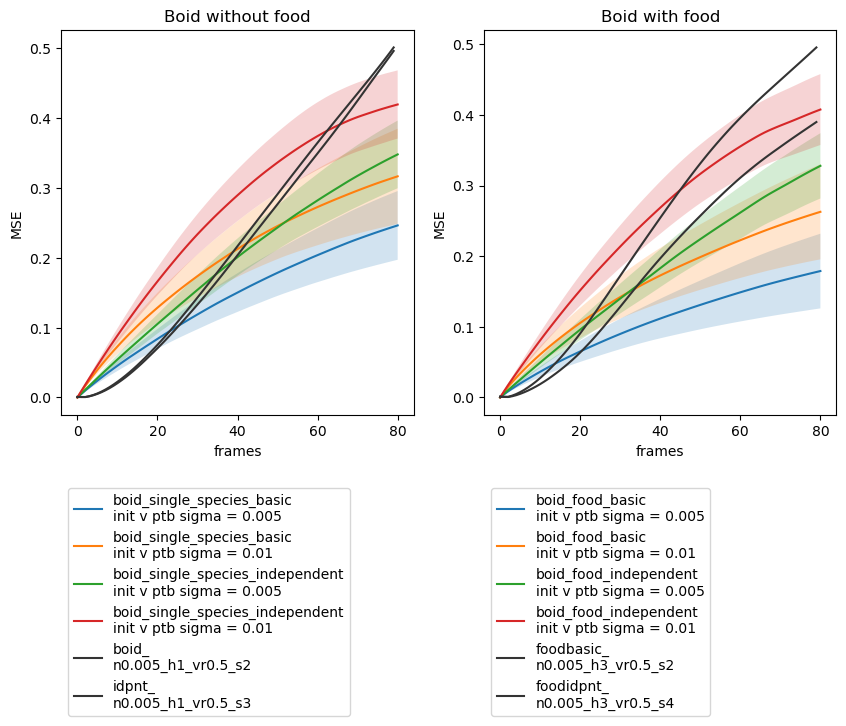

In [341]:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(10, 5))

for d_name in datasets:
    mean1, sd1 = diff[d_name]
    mean2, sd2 = diff2[d_name]

    if 'food' in d_name:
        ax = axes[1]
    else:
        ax = axes[0]
        
        
    ax.plot(mean1, label = d_name + "\ninit v ptb sigma = 0.005")
    ax.fill_between(np.arange(len(mean1)), mean1 - sd1, mean1 + sd1, alpha = 0.2)
    
    ax.plot(mean2, label = d_name + "\ninit v ptb sigma = 0.01")
    ax.fill_between(np.arange(len(mean2)), mean2 - sd2, mean2 + sd2, alpha = 0.2)
    
    ax.legend(bbox_to_anchor=(0, -0.6), loc='lower left')
    ax.set_xlabel("frames")
    ax.set_ylabel("MSE")

axes[0].set_title("Boid without food")
axes[1].set_title("Boid with food")

## add model

for m in rollout_results:
    data_name, model_name, n, h, vr, s, ablation = all_combinations[m]
    data_name_short = data_names_short[data_name]
    model_save_name = f'{data_name_short}_\nn{n}_h{h}_vr{vr}_s{s}'
    
    if "food" in model_names[m]:
        ax = axes[1]
    else:
        ax = axes[0]
    
    mse_by_frame, std_by_frame = return_mse(rollout_results[m][0], starting_frame, end_frame)
    ax.plot(mse_by_frame, label = model_save_name, color = [0.2, 0.2, 0.2])
    #ax.fill_between(np.arange(len(mse_by_frame)), mse_by_frame - std_by_frame, mse_by_frame + std_by_frame, alpha = 0.2)

axes[0].legend(bbox_to_anchor=(0, -0.8), loc='lower left')
axes[1].legend(bbox_to_anchor=(0, -0.8), loc='lower left')

if save_file:
    plt.savefig(f"initial velocity perturbation summary.pdf", bbox_inches="tight")